# Forecasting de Market Size por RegiÃ³n (EXSIM)

Este notebook prueba mÃºltiples enfoques de forecasting por **regiÃ³n** (tamaÃ±o de mercado, no ventas de una empresa individual), selecciona el mejor modelo **por regiÃ³n** con backtesting, y genera el pronÃ³stico para los prÃ³ximos periodos.

Notas rÃ¡pidas (porque a los humanos les encanta complicarse):
- El dataset es corto. Con pocas observaciones, el enfoque correcto es **comparar baselines simples** + 1â€“2 modelos estadÃ­sticos robustos, y evitar sobre-ajuste.
- En EXSIM hay estacionalidad por **temporada A/B/C** (3 periodos por aÃ±o). Vamos a tratar eso como estacionalidad de longitud **3**.
- Para regiones nuevas (East/South) con 1 dato, no hay magia: usamos un enfoque **cold-start** con patrones promedio de crecimiento + estacionalidad observada en regiones maduras.

---

## 0) ConfiguraciÃ³n


In [1]:
# Si corres esto en otro entorno, instala dependencias tÃ­picas:
# pip install pandas numpy scikit-learn statsmodels matplotlib

try:
    from statsmodels.tsa.holtwinters import ExponentialSmoothing
    from statsmodels.tsa.statespace.sarimax import SARIMAX
except ModuleNotFoundError:
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "statsmodels"])
    from statsmodels.tsa.holtwinters import ExponentialSmoothing
    from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from dataclasses import dataclass

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

DATA_PATH = "C:\\Users\\betoq\\OneDrive\\Documentos\\GitHub\\BusinessSim\\Marketing\\Forecast.csv"  # ajusta si mueves el archivo
FORECAST_HORIZON = 4  # default: 4 periodos (cubre un ciclo A/B/C)
SEASON_LENGTH = 3     # A/B/C
RANDOM_STATE = 7
LAST_COMPLETED_PERIOD = None  # set to 8 to lock; None = auto

pd.set_option('display.float_format', lambda x: f"{x:,.2f}")


## 1) Cargar y entender los datos

Esperamos columnas:
- `Region`
- `Periodo` (orden temporal dentro de la historia global)
- `Season` (A/B/C)
- `Total Sales` (tamaÃ±o de mercado en unidades monetarias o unidades, segÃºn tu definiciÃ³n)

Si tu archivo cambia, este bloque es donde se rompe primero.


In [2]:
df = pd.read_csv(DATA_PATH)
# Limpieza bÃ¡sica (tu CSV tiene BOM en algunos casos)
df.columns = [c.strip().replace('ï»¿','') for c in df.columns]

df = df.rename(columns={
    'Periodo': 'Period',
    'Total Sales': 'Sales'
})

df['Region'] = df['Region'].astype(str)
df['Season'] = df['Season'].astype(str)
df['Period'] = pd.to_numeric(df['Period'], errors='coerce')
df['Sales'] = pd.to_numeric(df['Sales'], errors='coerce')

df = df.dropna(subset=['Region','Season','Period','Sales']).sort_values(['Region','Period']).reset_index(drop=True)

last_completed_period = int(df['Period'].max()) if LAST_COMPLETED_PERIOD is None else int(LAST_COMPLETED_PERIOD)
df = df[df['Period'] <= last_completed_period].reset_index(drop=True)

df


,Region,Period,Season,Sales
0,Center,1,A,"28,700.00"
1,Center,2,B,"25,200.00"
2,Center,3,C,"46,200.00"
3,Center,4,A,"42,000.00"
4,Center,5,B,"35,700.00"
5,Center,6,C,"62,300.00"
6,Center,7,A,"55,262.41"
7,Center,8,B,"41,033.00"
8,East,7,A,"5,880.60"
9,East,8,B,"7,922.00"


In [3]:
print('Regiones:', df['Region'].unique())
print('Rango Period:', (df['Period'].min(), df['Period'].max()))
print('Obs por regiÃ³n:')
df.groupby('Region')['Sales'].size().sort_values(ascending=False)


Regiones: ['Center' 'East' 'North' 'South' 'West']
Rango Period: (np.int64(1), np.int64(8))
Obs por regiÃ³n:


Region
Center    8
North     8
West      8
East      2
South     2
Name: Sales, dtype: int64

## 2) Utilidades: mÃ©tricas y splits de backtesting

Con series cortas, hacemos **rolling-origin** con horizonte 1 (un paso adelante) y pocos splits.

MÃ©tricas:
- **sMAPE** (robusta y comparable)
- **RMSE** (penaliza errores grandes)

La selecciÃ³n se hace por regiÃ³n con una mÃ©trica principal (sMAPE) y RMSE como desempate.


In [4]:
def smape(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = (np.abs(y_true) + np.abs(y_pred) + eps)
    return np.mean(2.0 * np.abs(y_pred - y_true) / denom) * 100.0


def rmse(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return float(np.sqrt(np.mean((y_pred - y_true) ** 2)))


def rolling_splits(n, min_train=4, max_splits=3, h=1):
    # Genera pares (train_end_idx_exclusive, test_end_idx_exclusive)
    # Ej: train = [0:train_end), test = [train_end:train_end+h)
    splits = []
    last_train_end = n - h
    for train_end in range(min_train, last_train_end + 1):
        test_end = train_end + h
        if test_end <= n:
            splits.append((train_end, test_end))
    # toma los ultimos splits para privilegiar comportamiento reciente
    return splits[-max_splits:]


# sanity check
print(rolling_splits(n=7, min_train=4, max_splits=3, h=1))


[(4, 5), (5, 6), (6, 7)]


## 3) Modelos candidatos

Para cada regiÃ³n con historia suficiente, probamos:

1) **Naive**: Ãºltimo valor.
2) **Seasonal Naive** (m=3): Ãºltimo valor de la misma temporada.
3) **Drift**: tendencia lineal simple entre primer y Ãºltimo punto.
4) **RegresiÃ³n con dummies de Season + tendencia** (Ridge): Ãºtil cuando hay estacionalidad clara.
5) **ETS (Holt-Winters)**: nivel + tendencia + estacionalidad (si alcanza la data).
6) **SARIMAX simple**: ARIMA pequeÃ±o con estacionalidad m=3 (solo si converge y no se rompe).

Con 7 puntos, ETS y SARIMAX pueden fallar o sobre-ajustar. Por eso los metemos, pero con guardas.


In [5]:
def forecast_naive(y, h=1):
    return np.repeat(y[-1], h)


def forecast_seasonal_naive(y, seasons, h=1, m=3):
    # seasons es lista/array de etiquetas (A/B/C). Usamos mismo 'Season' futuro si se provee.
    # Si no, asumimos ciclo A,B,C.
    y = np.asarray(y)
    if len(y) < m:
        return forecast_naive(y, h)

    # Indice del ultimo punto
    last_idx = len(y) - 1

    # Para cada paso, buscamos el valor que este m pasos atras
    preds = []
    for i in range(1, h+1):
        idx = last_idx - (m - (i % m))
        # Forma facil: usar el valor de hace m pasos
        idx = last_idx - m + (i % m)
        idx = max(0, idx)
        preds.append(y[idx])
    return np.asarray(preds)


def forecast_drift(y, h=1):
    y = np.asarray(y, dtype=float)
    if len(y) < 2:
        return forecast_naive(y, h)
    slope = (y[-1] - y[0]) / (len(y) - 1)
    return np.asarray([y[-1] + slope * i for i in range(1, h+1)], dtype=float)


def fit_predict_ridge(df_region, h=1, future_seasons=None):
    # Modelo: Sales ~ trend (age) + Season (one-hot)
    d = df_region.copy().reset_index(drop=True)
    d['age'] = np.arange(1, len(d)+1)

    X = d[['age','Season']]
    y = d['Sales'].values

    pre = ColumnTransformer(
        transformers=[
            ('season', OneHotEncoder(handle_unknown='ignore'), ['Season']),
            ('num', 'passthrough', ['age'])
        ],
        remainder='drop'
    )

    model = Pipeline(steps=[
        ('pre', pre),
        ('ridge', Ridge(alpha=1.0, random_state=RANDOM_STATE))
    ])

    model.fit(X, y)

    last_age = d['age'].iloc[-1]

    if future_seasons is None:
        # asume ciclo A/B/C basado en el ultimo Season observado
        season_order = ['A','B','C']
        last_season = d['Season'].iloc[-1]
        try:
            start_idx = season_order.index(last_season)
        except ValueError:
            start_idx = 0
        future_seasons = [season_order[(start_idx + i) % 3] for i in range(1, h+1)]

    Xf = pd.DataFrame({
        'age': [last_age + i for i in range(1, h+1)],
        'Season': future_seasons
    })
    pred = model.predict(Xf)
    return np.asarray(pred, dtype=float)


def fit_predict_ets(df_region, h=1):
    y = df_region['Sales'].values.astype(float)
    # ETS con estacionalidad m=3 si hay datos suficientes
    if len(y) < 2*SEASON_LENGTH:
        # con < 6 obs, mejor no forzar estacionalidad
        model = ExponentialSmoothing(y, trend='add', seasonal=None, initialization_method='estimated')
    else:
        model = ExponentialSmoothing(y, trend='add', seasonal='add', seasonal_periods=SEASON_LENGTH, initialization_method='estimated')
    fit = model.fit(optimized=True)
    pred = fit.forecast(h)
    return np.asarray(pred, dtype=float)



def fit_predict_holt_winters(df_region, h=1):
    y = df_region['Sales'].values.astype(float)
    # Holt-Winters multiplicativo requiere datos > 0; si no, usamos aditivo.
    seasonal_mode = 'mul' if (y > 0).all() else 'add'
    if len(y) < 2*SEASON_LENGTH:
        # con < 6 obs, mejor no forzar estacionalidad
        model = ExponentialSmoothing(y, trend='add', seasonal=None, initialization_method='estimated')
    else:
        model = ExponentialSmoothing(y, trend='add', seasonal=seasonal_mode, seasonal_periods=SEASON_LENGTH, initialization_method='estimated')
    fit = model.fit(optimized=True)
    pred = fit.forecast(h)
    return np.asarray(pred, dtype=float)

def fit_predict_sarimax(df_region, h=1):
    y = df_region['Sales'].values.astype(float)
    # ARIMA pequeno + seasonal (m=3)
    # Ojo: con series cortas puede no converger. Por eso try/except.
    order = (1,1,0)
    seasonal_order = (0,1,1,SEASON_LENGTH)
    model = SARIMAX(y, order=order, seasonal_order=seasonal_order, trend='c', enforce_stationarity=False, enforce_invertibility=False)
    fit = model.fit(disp=False)
    pred = fit.forecast(h)
    return np.asarray(pred, dtype=float)


MODEL_REGISTRY = {
    'naive': lambda d, h: forecast_naive(d['Sales'].values, h),
    'seasonal_naive': lambda d, h: forecast_seasonal_naive(d['Sales'].values, d['Season'].values, h, m=SEASON_LENGTH),
    'drift': lambda d, h: forecast_drift(d['Sales'].values, h),
    'ridge_season_trend': lambda d, h: fit_predict_ridge(d, h=h),
    'ets': lambda d, h: fit_predict_ets(d, h=h),
    'holt_winters': lambda d, h: fit_predict_holt_winters(d, h=h),
    'sarimax': lambda d, h: fit_predict_sarimax(d, h=h),
}


## 4) Backtesting por regiÃ³n y selecciÃ³n del mejor modelo

Estrategia:
- Para cada regiÃ³n con al menos `min_train + 1` observaciones, hacemos rolling-origin con `h=1`.
- Evaluamos cada modelo en cada split.
- Agregamos mÃ©tricas por modelo: sMAPE promedio y RMSE promedio.
- Elegimos el modelo con menor sMAPE (y menor RMSE si empata).

Si un modelo truena (ETS/SARIMAX a veces), lo marcamos como `fail` y seguimos.


In [6]:
@dataclass
class ModelScore:
    model: str
    smape: float
    rmse: float
    n_splits: int


def evaluate_models_for_region(df_region, min_train=4, max_splits=3, h=1):
    d = df_region.sort_values('Period').reset_index(drop=True)
    n = len(d)
    splits = rolling_splits(n=n, min_train=min_train, max_splits=max_splits, h=h)
    if len(splits) == 0:
        return []

    results = []

    for name, fn in MODEL_REGISTRY.items():
        preds_all = []
        y_all = []
        ok = True

        for train_end, test_end in splits:
            train = d.iloc[:train_end].copy()
            test = d.iloc[train_end:test_end].copy()
            try:
                pred = fn(train, h=h)
                preds_all.extend(list(pred))
                y_all.extend(list(test['Sales'].values))
            except Exception as e:
                ok = False
                break

        if ok:
            results.append(ModelScore(
                model=name,
                smape=smape(y_all, preds_all),
                rmse=rmse(y_all, preds_all),
                n_splits=len(splits)
            ))

    results = sorted(results, key=lambda r: (r.smape, r.rmse))
    return results


def pick_best_model(scores):
    if not scores:
        return None
    return scores[0]


region_scores = {}
for region, dreg in df.groupby('Region'):
    scores = evaluate_models_for_region(dreg, min_train=4, max_splits=3, h=1)
    region_scores[region] = scores

# Mostrar resultados
rows = []
for region, scores in region_scores.items():
    for s in scores:
        rows.append({'Region': region, 'Model': s.model, 'sMAPE': s.smape, 'RMSE': s.rmse, 'Splits': s.n_splits})

scores_df = pd.DataFrame(rows).sort_values(['Region','sMAPE','RMSE'])
scores_df


,Region,Model,sMAPE,RMSE,Splits
0,Center,holt_winters,15.15,"10,504.20",3
1,Center,ets,15.70,"10,747.13",3
2,Center,ridge_season_trend,15.93,"9,788.91",3
3,Center,seasonal_naive,23.62,"12,430.37",3
4,Center,naive,31.94,"17,884.48",3
5,Center,drift,36.34,"19,620.21",3
6,North,ridge_season_trend,8.19,"2,916.11",3
7,North,ets,9.38,"3,321.51",3
8,North,holt_winters,11.80,"3,500.85",3
9,North,drift,16.94,"5,977.91",3


In [7]:
best_by_region = {}
for region, scores in region_scores.items():
    best = pick_best_model(scores)
    best_by_region[region] = best.model if best else None

best_by_region


{'Center': 'holt_winters',
 'East': None,
 'North': 'ridge_season_trend',
 'South': None,
 'West': 'ridge_season_trend'}

## 5) PronÃ³stico final por regiÃ³n (usando el mejor modelo)

Ahora re-entrenamos el mejor modelo de cada regiÃ³n con toda su historia y pronosticamos `FORECAST_HORIZON` periodos.

AdemÃ¡s, graficamos historia vs forecast.


In [8]:
def forecast_with_model(df_region, model_name, h=3):
    d = df_region.sort_values('Period').reset_index(drop=True)
    if model_name is None:
        return forecast_naive(d['Sales'].values, h)
    fn = MODEL_REGISTRY.get(model_name)
    if fn is None:
        return forecast_naive(d['Sales'].values, h)
    try:
        return fn(d, h=h)
    except Exception:
        return forecast_naive(d['Sales'].values, h)


def get_future_seasons(last_season, h=3):
    season_order = ['A','B','C']
    try:
        start = season_order.index(last_season)
    except ValueError:
        start = 0
    return [season_order[(start + i) % 3] for i in range(1, h+1)]


forecasts = []
for region, dreg in df.groupby('Region'):
    dreg = dreg.sort_values('Period').reset_index(drop=True)
    model_name = best_by_region.get(region)

    last_period = int(dreg['Period'].iloc[-1])
    last_season = dreg['Season'].iloc[-1]

    yhat = forecast_with_model(dreg, model_name, h=FORECAST_HORIZON)

    future_periods = [last_period + i for i in range(1, FORECAST_HORIZON+1)]
    future_seasons = get_future_seasons(last_season, h=FORECAST_HORIZON)

    for p, s, yh in zip(future_periods, future_seasons, yhat):
        forecasts.append({
            'Region': region,
            'Model': model_name,
            'Period': p,
            'Season': s,
            'Forecast_Sales': float(yh)
        })

forecast_df = pd.DataFrame(forecasts)
forecast_df


,Region,Model,Period,Season,Forecast_Sales
0,Center,holt_winters,9,C,"71,293.86"
1,Center,holt_winters,10,A,"62,518.87"
2,Center,holt_winters,11,B,"48,542.54"
3,Center,holt_winters,12,C,"83,591.31"
4,East,None,9,C,"7,922.00"
5,East,None,10,A,"7,922.00"
6,East,None,11,B,"7,922.00"
7,East,None,12,C,"7,922.00"
8,North,ridge_season_trend,9,C,"40,198.97"
9,North,ridge_season_trend,10,A,"40,058.11"


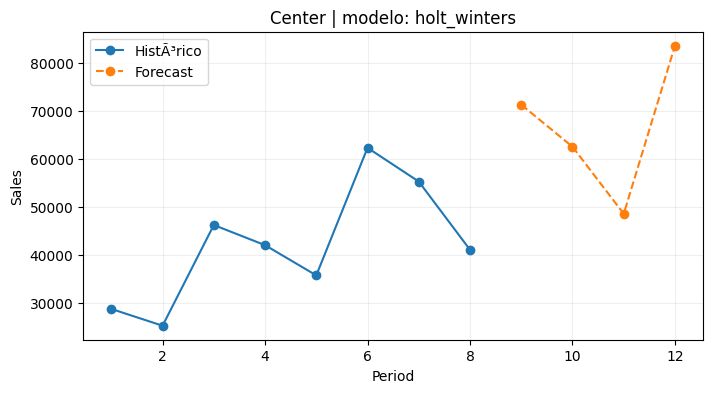

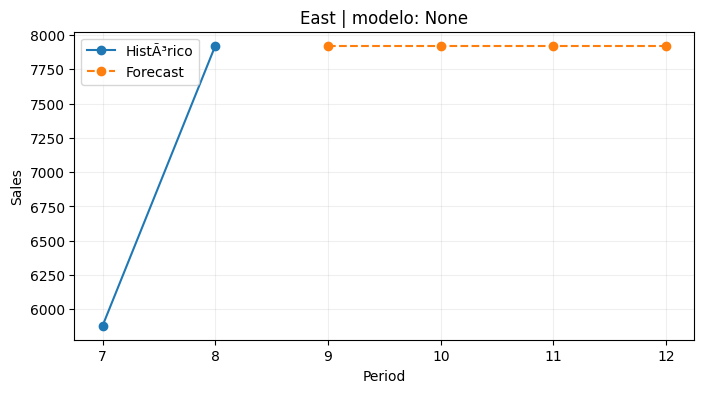

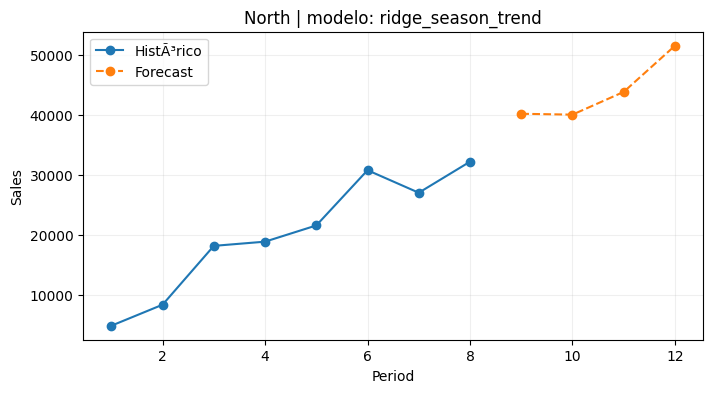

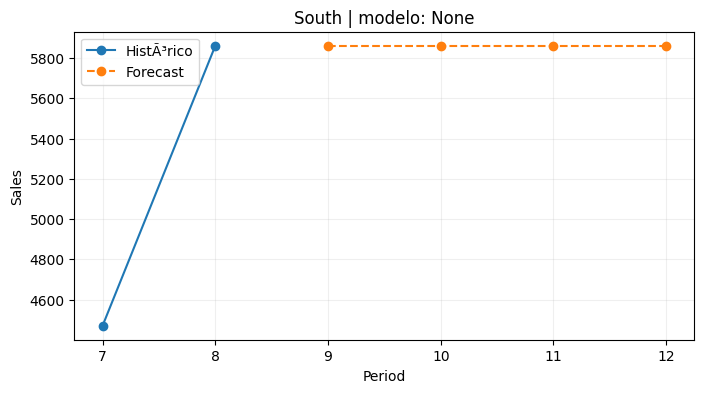

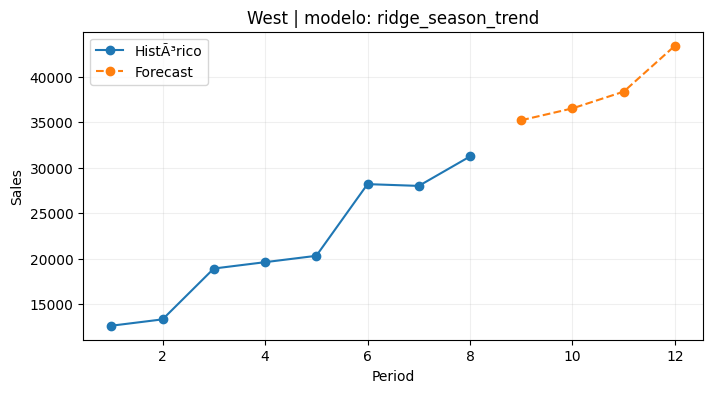

In [9]:
# Visualizacion por region
for region, dreg in df.groupby('Region'):
    dreg = dreg.sort_values('Period').reset_index(drop=True)
    f = forecast_df[forecast_df['Region']==region].sort_values('Period')

    plt.figure(figsize=(8,4))
    plt.plot(dreg['Period'], dreg['Sales'], marker='o', label='HistÃ³rico')
    plt.plot(f['Period'], f['Forecast_Sales'], marker='o', linestyle='--', label='Forecast')
    plt.title(f"{region} | modelo: {best_by_region.get(region)}")
    plt.xlabel('Period')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(True, alpha=0.2)
    plt.show()


## 6) Cold-start para regiones nuevas (East/South) con 1 observaciÃ³n

Si una regiÃ³n tiene 1 dato, *no puedes* validar modelos. Lo razonable es:

1) Anclar el pronÃ³stico al nivel inicial observado.
2) Aplicar patrones promedio de crecimiento por "edad" (age) aprendidos de regiones maduras.
3) Ajustar por estacionalidad A/B/C.

Este bloque crea un pronÃ³stico alternativo "cold-start" y lo compara con lo que haya salido arriba.

Cuando tengas mÃ¡s periodos (8, 9, ...), **apaga este bloque** y deja que la selecciÃ³n automÃ¡tica por regiÃ³n haga su chamba.


In [10]:
# Construir factores promedio de crecimiento por edad usando regiones con historia >= 5
mature = df.groupby('Region').filter(lambda x: len(x) >= 5).copy()

# Creamos 'age' dentro de cada region (1..n)
mature['age'] = mature.groupby('Region').cumcount() + 1

# Growth factor de age t -> t+1
mature = mature.sort_values(['Region','age'])
mature['next_sales'] = mature.groupby('Region')['Sales'].shift(-1)
mature['growth'] = mature['next_sales'] / mature['Sales']

avg_growth_by_age = mature.groupby('age')['growth'].mean().dropna()
avg_growth_by_age


age
1   1.22
2   1.81
3   0.99
4   1.01
5   1.52
6   0.92
7   1.02
Name: growth, dtype: float64

In [11]:
# Estacionalidad promedio por Season (multiplicativo) usando regiones maduras
season_avg = mature.groupby('Season')['Sales'].mean()
season_factor = season_avg / season_avg.mean()
season_factor


Season
A   0.92
B   0.89
C   1.19
Name: Sales, dtype: float64

In [12]:
def cold_start_forecast(df_region, h=3):
    d = df_region.sort_values('Period').reset_index(drop=True)
    base = float(d['Sales'].iloc[-1])
    last_season = d['Season'].iloc[-1]

    future_seasons = get_future_seasons(last_season, h=h)

    # Asumimos que estamos en age=1 (primer dato en esa region)
    age = 1
    preds = []
    level = base
    for step in range(1, h+1):
        g = float(avg_growth_by_age.get(age, avg_growth_by_age.mean()))
        level = level * g
        age += 1
        # Ajuste estacional multiplicativo
        sf = float(season_factor.get(future_seasons[step-1], 1.0))
        preds.append(level * sf)
    return np.asarray(preds, dtype=float)


cold_rows = []
for region, dreg in df.groupby('Region'):
    if len(dreg) <= 2:
        dreg = dreg.sort_values('Period').reset_index(drop=True)
        last_period = int(dreg['Period'].iloc[-1])
        last_season = dreg['Season'].iloc[-1]
        future_periods = [last_period + i for i in range(1, FORECAST_HORIZON+1)]
        future_seasons = get_future_seasons(last_season, h=FORECAST_HORIZON)
        yhat = cold_start_forecast(dreg, h=FORECAST_HORIZON)
        for p, s, yh in zip(future_periods, future_seasons, yhat):
            cold_rows.append({'Region': region, 'Period': p, 'Season': s, 'ColdStart_Forecast': float(yh)})

cold_df = pd.DataFrame(cold_rows)
cold_df


,Region,Period,Season,ColdStart_Forecast
0,East,9,C,"11,474.67"
1,East,10,A,"16,013.40"
2,East,11,B,"15,392.44"
3,East,12,C,"20,824.89"
4,South,9,C,"8,489.40"
5,South,10,A,"11,847.33"
6,South,11,B,"11,387.92"
7,South,12,C,"15,407.05"


In [13]:
# Comparacion: forecast automatico vs cold-start (solo para regiones nuevas)
compare = forecast_df.merge(cold_df, on=['Region','Period','Season'], how='inner')
compare


,Region,Model,Period,Season,Forecast_Sales,ColdStart_Forecast
0,East,None,9,C,"7,922.00","11,474.67"
1,East,None,10,A,"7,922.00","16,013.40"
2,East,None,11,B,"7,922.00","15,392.44"
3,East,None,12,C,"7,922.00","20,824.89"
4,South,None,9,C,"5,861.00","8,489.40"
5,South,None,10,A,"5,861.00","11,847.33"
6,South,None,11,B,"5,861.00","11,387.92"
7,South,None,12,C,"5,861.00","15,407.05"


## 7) Output listo para copiar/pegar a Excel o a tu flujo

La tabla final recomendada:
- HistÃ³ricos (para auditorÃ­a)
- Forecast por regiÃ³n
- Campo `Model` para saber quÃ© ganÃ³

Si quieres producir directamente un CSV con el forecast, aquÃ­ lo hacemos.


In [14]:
out = forecast_df.copy()

# Si existe cold-start, lo usamos para regiones con <=2 obs
if not cold_df.empty:
    out = out.merge(cold_df, on=['Region','Period','Season'], how='left')
    out['Forecast_Sales_Final'] = np.where(
        out['ColdStart_Forecast'].notna(),
        out['ColdStart_Forecast'],
        out['Forecast_Sales']
    )
else:
    out['Forecast_Sales_Final'] = out['Forecast_Sales']

out = out.sort_values(['Region','Period']).reset_index(drop=True)
out


,Region,Model,Period,Season,Forecast_Sales,ColdStart_Forecast,Forecast_Sales_Final
0,Center,holt_winters,9,C,"71,293.86",NaN,"71,293.86"
1,Center,holt_winters,10,A,"62,518.87",NaN,"62,518.87"
2,Center,holt_winters,11,B,"48,542.54",NaN,"48,542.54"
3,Center,holt_winters,12,C,"83,591.31",NaN,"83,591.31"
4,East,None,9,C,"7,922.00","11,474.67","11,474.67"
5,East,None,10,A,"7,922.00","16,013.40","16,013.40"
6,East,None,11,B,"7,922.00","15,392.44","15,392.44"
7,East,None,12,C,"7,922.00","20,824.89","20,824.89"
8,North,ridge_season_trend,9,C,"40,198.97",NaN,"40,198.97"
9,North,ridge_season_trend,10,A,"40,058.11",NaN,"40,058.11"


In [15]:
OUTPUT_CSV = "C:\\Users\\betoq\\OneDrive\\Documentos\\GitHub\\BusinessSim\\Marketing\\ForecastOutput.csv"
out.to_csv(OUTPUT_CSV, index=False)
print('Guardado:', OUTPUT_CSV)


Guardado: C:\Users\betoq\OneDrive\Documentos\GitHub\BusinessSim\Marketing\ForecastOutput.csv


## 8) QuÃ© tocar cuando tengas mÃ¡s datos

- Sube `FORECAST_HORIZON` a lo que realmente necesites (1 para decisiones del siguiente periodo, 3 para cubrir el ciclo, etc.).
- Si agregas `Month`/`Date`, puedes pasar a Ã­ndices de tiempo reales y usar validaciÃ³n mÃ¡s limpia.
- Con 12+ puntos por regiÃ³n, ETS/SARIMAX empiezan a ser mÃ¡s confiables.
- Si quieres algo mÃ¡s serio: modelo jerÃ¡rquico (global + regiÃ³n) o Bayesian structural time series. Con 7 puntos, eso es teatro.
